In [40]:
import geopandas
from shapely.geometry import Point, Polygon
import plotly.express as ex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.shx
/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.dbf
/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.shp
/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.shp.iso.xml
/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.cpg
/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.prj
/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.shp.ea.iso.xml
/kaggle/input/us-airbnb-open-data/AB_US_2020.csv


In [82]:
data = pd.read_csv ('/kaggle/input/us-airbnb-open-data/AB_US_2020.csv', low_memory=False)   
bnb = pd.DataFrame(data)
print(bnb.shape)

(226030, 17)


In [42]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,07/09/20,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


Checking for missing values

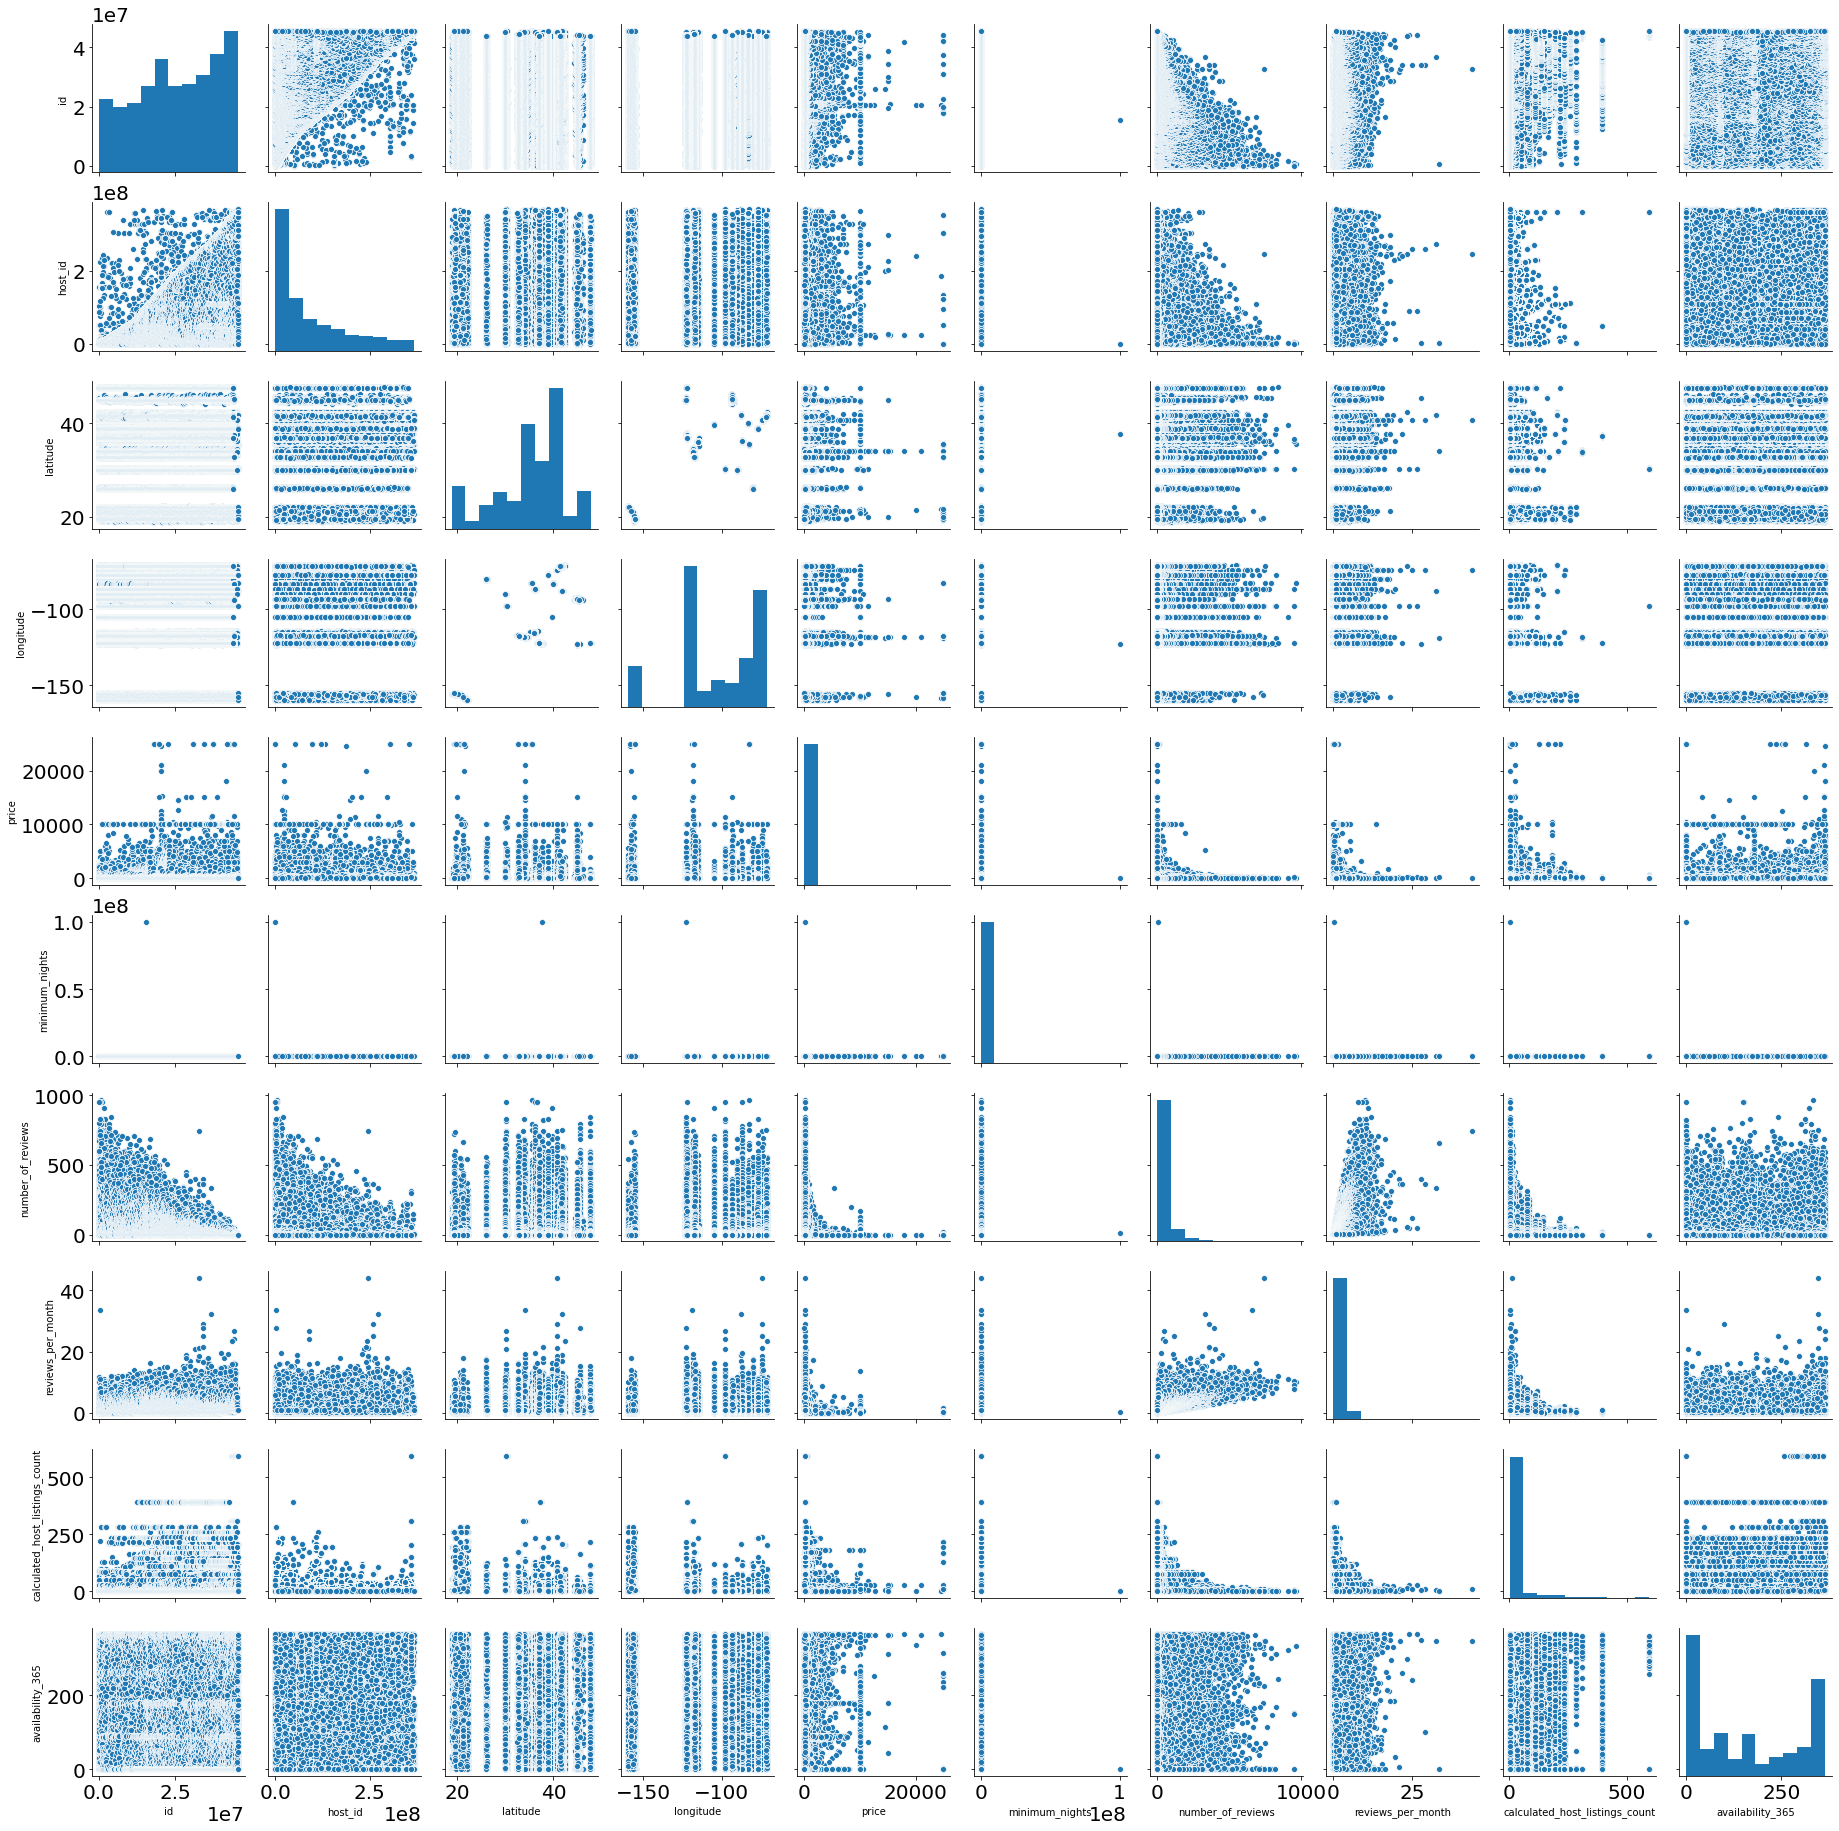

In [43]:
sns.pairplot(bnb)

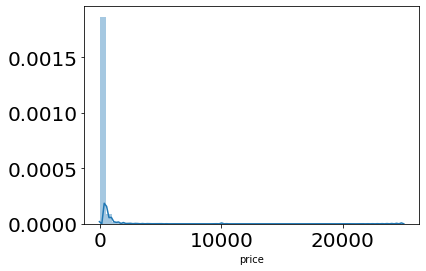

In [44]:
sns.distplot(bnb['price'])

In [83]:
print(bnb.isnull().any())

id                                False
name                               True
host_id                           False
host_name                          True
neighbourhood_group                True
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                        True
reviews_per_month                  True
calculated_host_listings_count    False
availability_365                  False
city                              False
dtype: bool


In [84]:
miss = bnb.isna().sum()
miss /= bnb.shape[0]
miss *=100
miss = miss.to_frame().rename(columns={0:'Precentage Of Missing Values'})
miss

,Precentage Of Missing Values
id,0.000000
name,0.012388
host_id,0.000000
host_name,0.014600
neighbourhood_group,51.252046
neighbourhood,0.000000
latitude,0.000000
longitude,0.000000
room_type,0.000000
price,0.000000


Some of the columns present null values with different percentage. Soo, we can start setting id as index and fixing all the null-values columns then after some data visualization we can see which remove and which keep in the analysis. Btw this is my first opinion for the variables: 

- DROP : name, host_name, neighbourhood_group (more than 40% is already "other"), last_review

For the moment just try to fill all the null values and then let's drop something

In [47]:
bnb = bnb.set_index('id')

In [85]:
bnb['name'] = bnb['name'].fillna("Airbnb House")
bnb['host_name'] = bnb['host_name'].fillna('Airbnb Host')
bnb['neighbourhood_group'] = bnb['neighbourhood_group'].fillna('Other')
bnb['reviews_per_month'] = bnb['reviews_per_month'].fillna(0) 
bnb['last_review'] = bnb['last_review'].fillna('01/01/01')
bnb['last_review'] = pd.to_datetime(bnb['last_review']) 

In [86]:
print(bnb.isnull().any())

id                                False
name                              False
host_id                           False
host_name                         False
neighbourhood_group               False
neighbourhood                     False
latitude                          False
longitude                         False
room_type                         False
price                             False
minimum_nights                    False
number_of_reviews                 False
last_review                       False
reviews_per_month                 False
calculated_host_listings_count    False
availability_365                  False
city                              False
dtype: bool


In [88]:
bnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,Other,28804,35.65146,-82.62792,Private room,60,1,138,2020-02-16,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,Other,28801,35.59779,-82.55540,Entire home/apt,470,1,114,2020-07-09,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,Other,28801,35.60670,-82.55563,Entire home/apt,75,30,89,2019-11-30,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,Other,28806,35.57864,-82.59578,Entire home/apt,90,1,267,2020-09-22,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,Other,28801,35.61442,-82.54127,Private room,125,30,58,2015-10-19,0.52,1,0,Asheville


In [51]:
bnb.dtypes

name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
city                                      object
dtype: object

### **Data Visualization**

I would like to focus first on the cities, to have a better understanding of the distribution of the houses all over the country.

In [52]:
df_coord = bnb.filter(['city','latitude','longitude'], axis = 1)
cities = list(set(bnb['city']))
bnb.loc[bnb['city'].isin(cities),'city'].value_counts()

New York City        45756
Los Angeles          31536
Hawaii               22434
San Diego            12404
Broward County       10858
Austin               10436
Clark County          8408
Washington D.C.       7350
San Clara Country     7091
San Francisco         7053
Seattle               6575
Twin Cities MSA       6470
New Orleans           6408
Chicago               6397
Nashville             6139
Portland              4281
Denver                4200
Rhode Island          3884
Boston                3339
Oakland               3204
San Mateo County      2855
Jersey City           2488
Asheville             2074
Santa Cruz County     1571
Columbus              1409
Cambridge             1029
Salem                  202
Pacific Grove          179
Name: city, dtype: int64

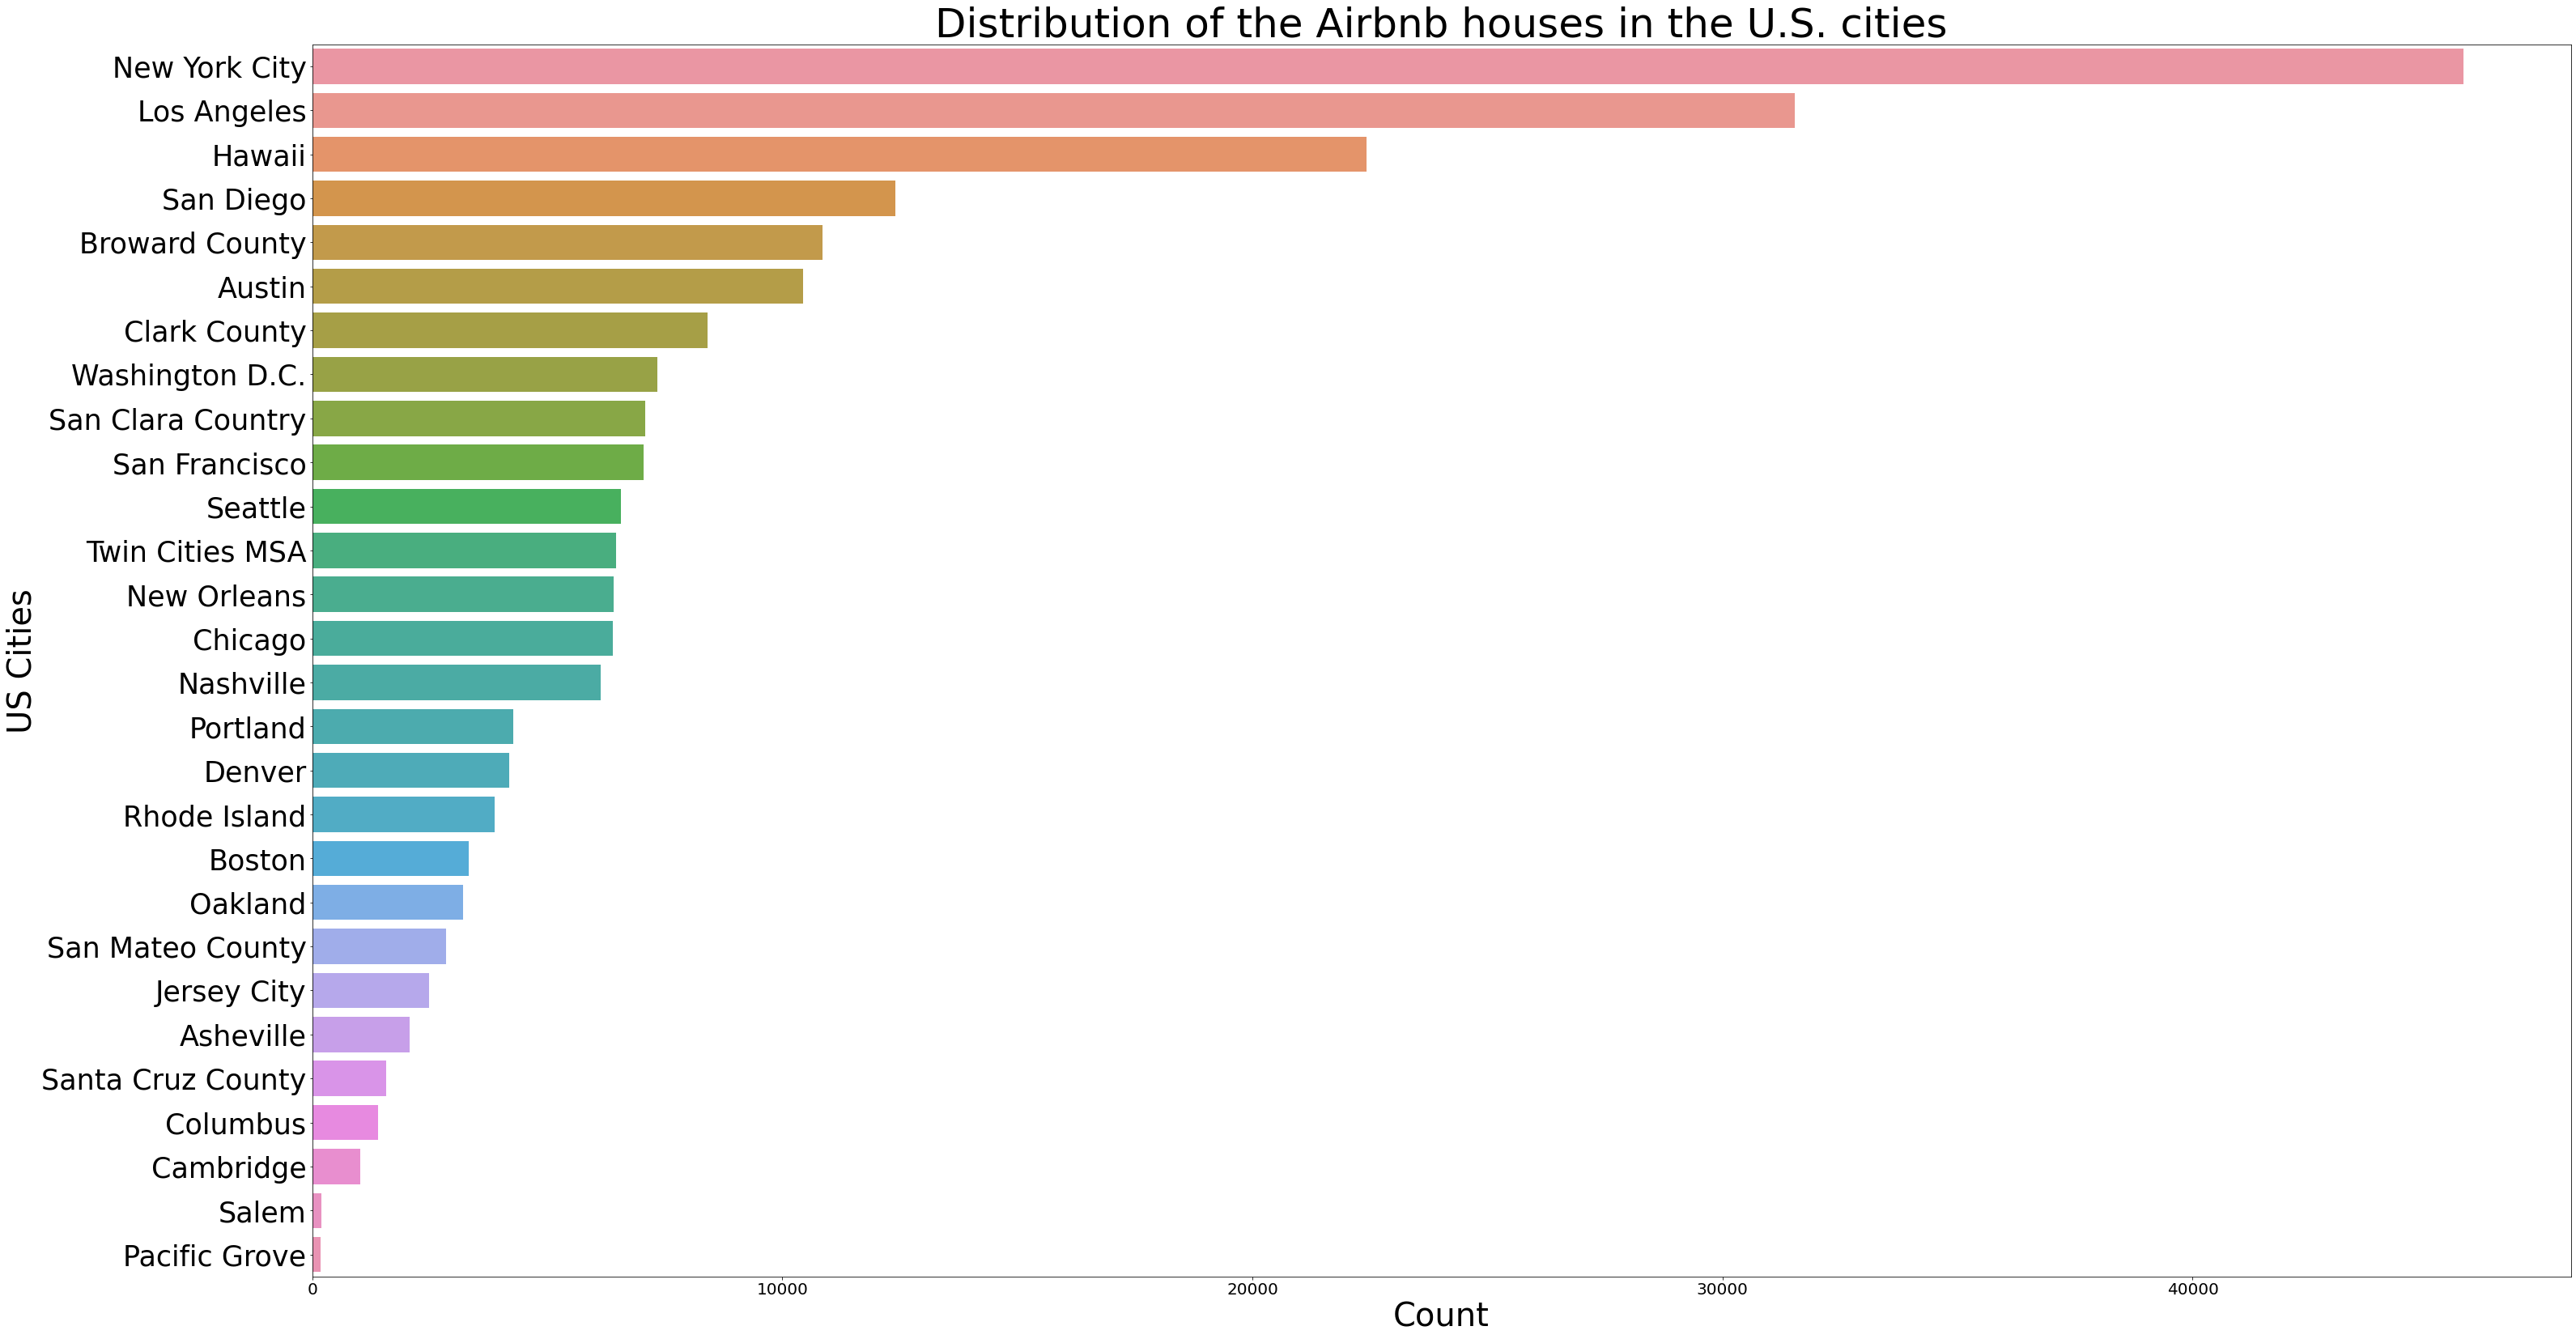

In [53]:
plt.figure(1, figsize=(50, 28)) 
ax = sns.countplot(y=bnb['city'],order=bnb['city'].value_counts().index)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=35)
plt.rc('xtick',labelsize=30)
ax.set_title('Distribution of the Airbnb houses in the U.S. cities',fontsize=50)
ax.set_xlabel('Count',fontsize=40)
ax.set_ylabel('US Cities', fontsize=40)
plt.show()

In [54]:
gdf = geopandas.GeoDataFrame(
    df_coord, geometry=geopandas.points_from_xy(df_coord.longitude, df_coord.latitude))

In [55]:
states = geopandas.read_file('/kaggle/input/american-geopandas-map/cb_2018_us_state_20m.shp')
type(states)

geopandas.geodataframe.GeoDataFrame

In [56]:
states = states.drop(25) # Drop Alaska
states = states.drop(7) # Drop PuertoRico

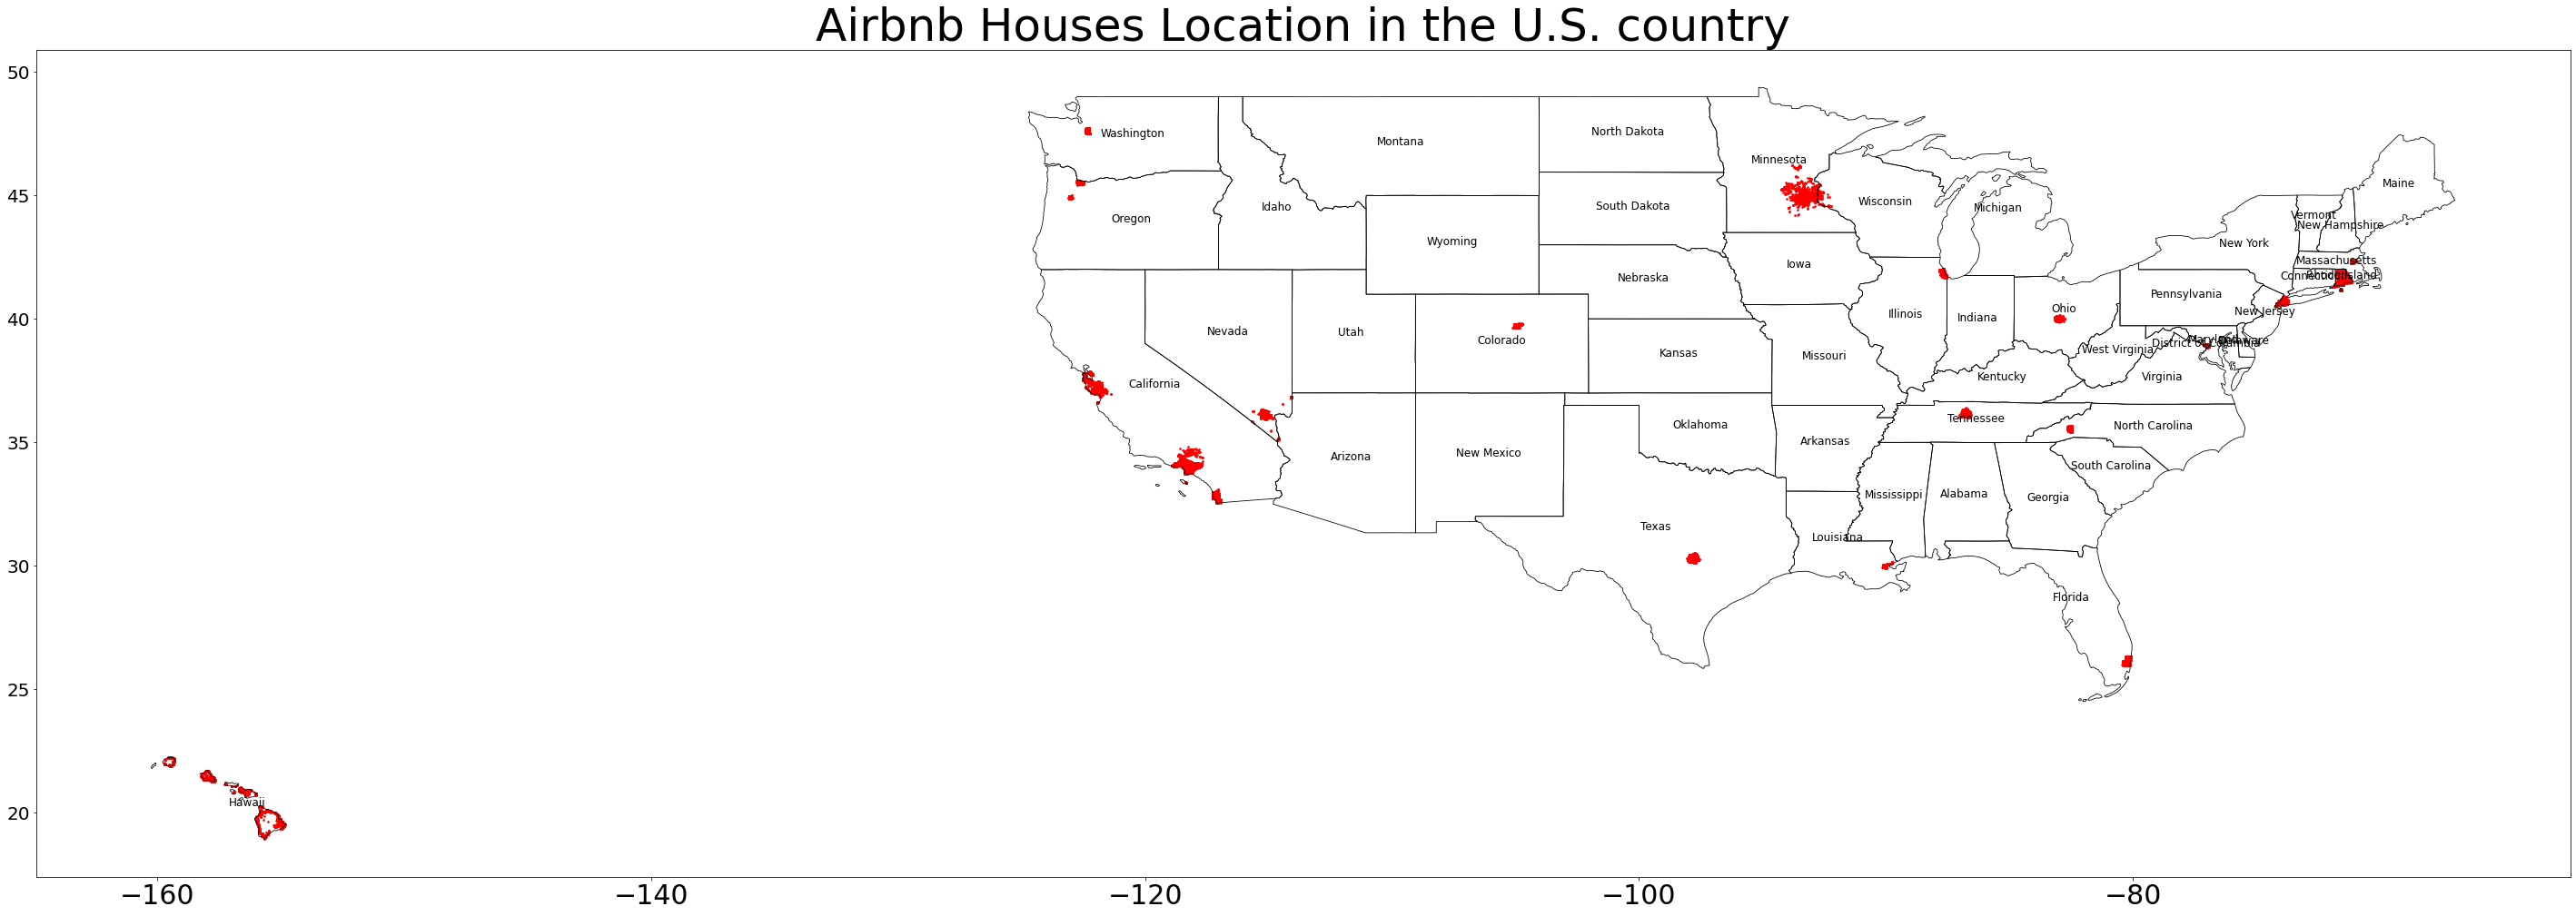

In [57]:
fig = plt.figure(1, figsize=(50, 28)) 

ax = fig.add_subplot()
plt.title('Airbnb Houses Location in the U.S. country', fontsize=50)
states.boundary.plot(ax=ax, color='black', linewidth=.8)
states.apply(lambda x: ax.annotate(s=x.NAME, xy=x.geometry.centroid.coords[0], ha='center', fontsize=12),axis=1);
gdf.plot(ax=ax, color='red', marker='.', markersize=10)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.show()

Let's create a dictionary to have the state for each city and to plot them.

In [58]:
states_dic = {'Asheville':'NC','Austin':'TX','Boston':'MA','Broward County':'FL','Cambridge':'MA','Chicago':'IL','Clark County':'NV','Columbus':'OH','Denver':'CO','Hawaii':'HI','Jersey City':'NJ',
             'Los Angeles':'CA','Nashville':'TN','New Orleans':'LA','New York City':'NY','Oakland':'CA','Pacific Grove':'CA','Portland':'OR','Rhode Island':'RI','Salem':'MA','San Clara Country':'CA',
             'Santa Cruz County':'CA','San Diego':'CA','San Francisco':'CA','San Mateo County':'CA','Seattle':'WA','Twin Cities MSA':'MN','Washington D.C.':'DC'}

bnb['state'] = bnb['city'].apply(lambda x : states_dic[x])

In [60]:
houses = bnb['state'].value_counts()
fig = ex.choropleth(locations=houses.index,color=houses.values, locationmode="USA-states", 
                    scope="usa",title='Distribution of houses by State', 
                    color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

In [61]:
price_med = round(bnb.groupby(by='state').mean(),2)
fig = ex.choropleth(price_med,locations=price_med.index,color='price', locationmode="USA-states",
                    scope="usa",title='Average price of houses in each State', 
                    color_continuous_scale=ex.colors.diverging.Portland)
fig.show()

So most of the houses are located in California but the most expensive ones are in Minnesota.

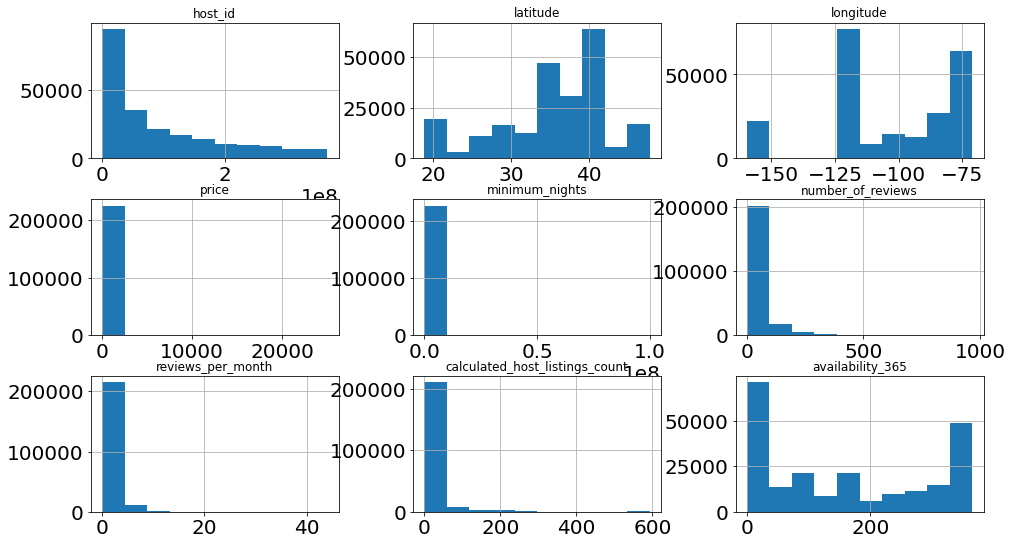

In [63]:
bnb.hist()
plt.rcParams["figure.figsize"] = [16,9]
plt.show()

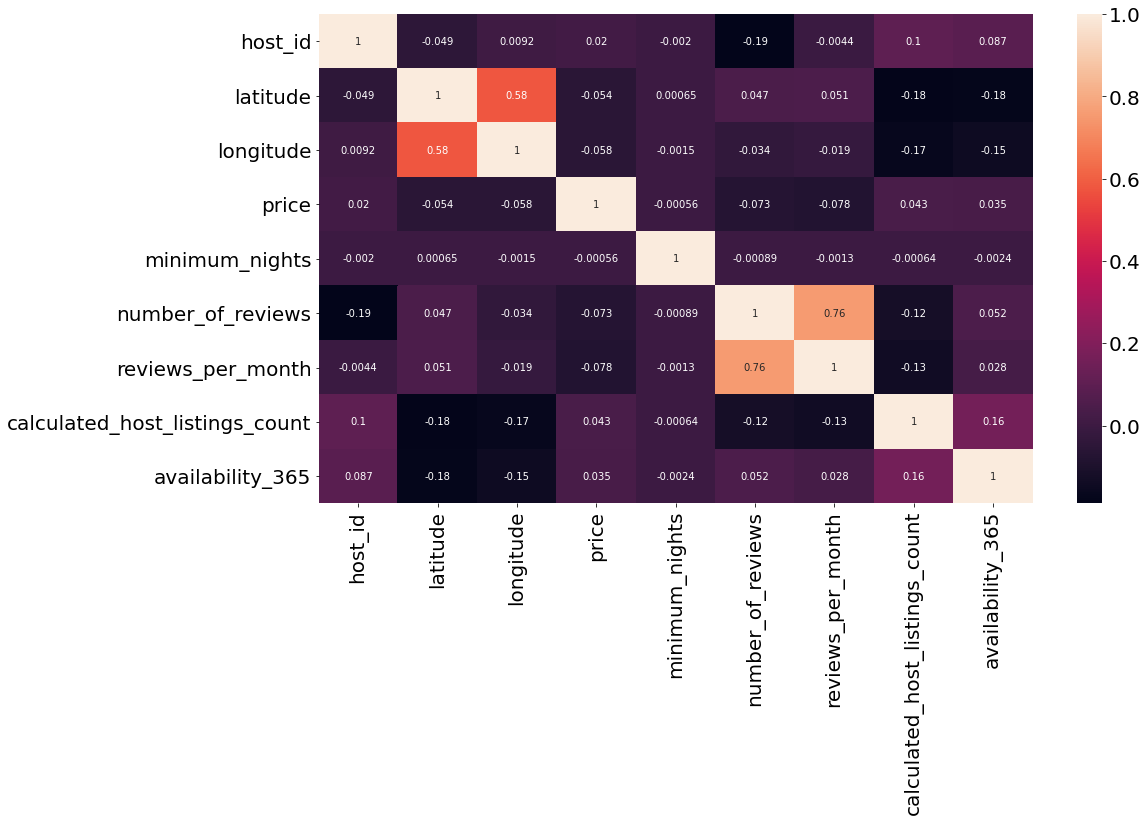

In [64]:
corrMatrix = bnb.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [89]:
bnb_x = bnb.copy()
bnb_x.drop(['name','host_name','last_review'],axis=1,inplace=True)

In [113]:
labelencoder = LabelEncoder()
bnb_x['neighbourhood'] = labelencoder.fit_transform(bnb_x["neighbourhood"])

In [91]:
dmm = pd.get_dummies(bnb_x.neighbourhood_group, prefix='NG')
dmm1 = pd.get_dummies(bnb_x.room_type, prefix='RT')
dmm2 = pd.get_dummies(bnb_x.city, prefix = 'CY')
#dmm3 = pd.get_dummies(bnb_x.state, prefix= 'ST')

In [92]:
bnb_x = bnb_x.join(dmm)
bnb_x = bnb_x.join(dmm1)
bnb_x = bnb_x.join(dmm2)
#bnb_x = bnb_x.join(dmm3)

In [103]:
bnb_x.drop(['room_type','neighbourhood_group'],axis=1,inplace=True)
bnb_x.drop(['city'],axis=1,inplace=True)

In [116]:
X = bnb_x
y = bnb_x.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Linear Regression

In [105]:
print(bnb_x.isnull().any())

id                      False
host_id                 False
neighbourhood           False
latitude                False
longitude               False
                        ...  
CY_San Mateo County     False
CY_Santa Cruz County    False
CY_Seattle              False
CY_Twin Cities MSA      False
CY_Washington D.C.      False
Length: 78, dtype: bool


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [119]:
lr = LinearRegression()

In [120]:
lr.fit(X_train, y_train)

LinearRegression()

In [121]:
print(lr.intercept_)

-3.699730655171152e-08


In [124]:
print(lr.coef_)

[ 2.01237174e-15 -1.51425986e-16  1.05471187e-15 -1.40387701e-12
  2.19185781e-13  1.00000000e+00 -1.81538812e-15  3.25043811e-16
  1.74352178e-13 -3.01668412e-15  6.50521303e-19 -2.77224167e-12
 -8.31405596e-12  6.28029284e-12  6.37291952e-12  1.67932576e-12
 -1.19788817e-12 -4.91349382e-12 -3.55971139e-12 -1.04001641e-12
 -1.04394831e-11 -1.56346529e-11 -1.11144454e-11 -3.19184186e-12
  1.00931226e-10 -7.57434336e-13  3.94702956e-12  2.99046055e-12
  5.52964718e-12  8.16238722e-13  3.45513177e-12 -1.54206809e-11
  1.08262107e-11 -2.63795756e-12 -1.28324151e-13 -1.66023155e-11
 -6.81763240e-12 -7.22921821e-12  5.06420604e-12 -2.42671664e-12
 -1.25592050e-11 -2.02119159e-11 -2.58357548e-12  1.42795773e-11
  1.19212247e-11 -2.45419545e-11 -6.29535893e-12  1.11975424e-13
 -6.71173578e-12  1.28951000e-11 -1.44010786e-11 -1.02519648e-11
 -5.45812950e-14 -2.21337593e-11  7.67915207e-12  1.81187838e-12
  3.38273605e-13 -1.60187220e-12  7.43161656e-12 -1.16087992e-11
  1.18582126e-12 -3.75209

In [125]:
cdf = pd.DataFrame(lr.coef_,bnb_x.columns, columns = ['Coeff'])

In [126]:
cdf

,Coeff
id,2.012372e-15
host_id,-1.514260e-16
neighbourhood,1.054712e-15
latitude,-1.403877e-12
longitude,2.191858e-13
...,...
CY_San Mateo County,-4.888402e-12
CY_Santa Cruz County,1.042146e-11
CY_Seattle,2.436619e-11
CY_Twin Cities MSA,7.831860e-12


## Predictions

In [127]:
predictions = lr.predict(X_test)

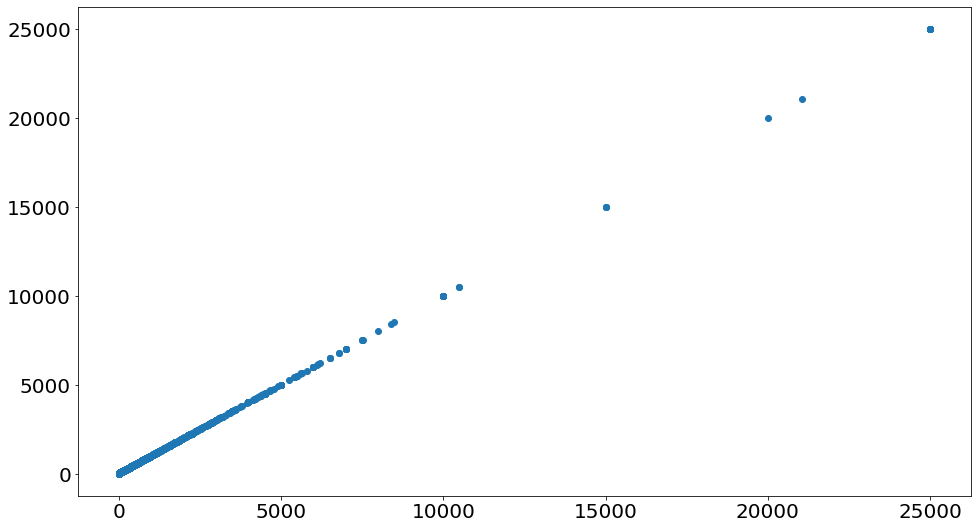

In [129]:
plt.scatter(y_test,predictions)

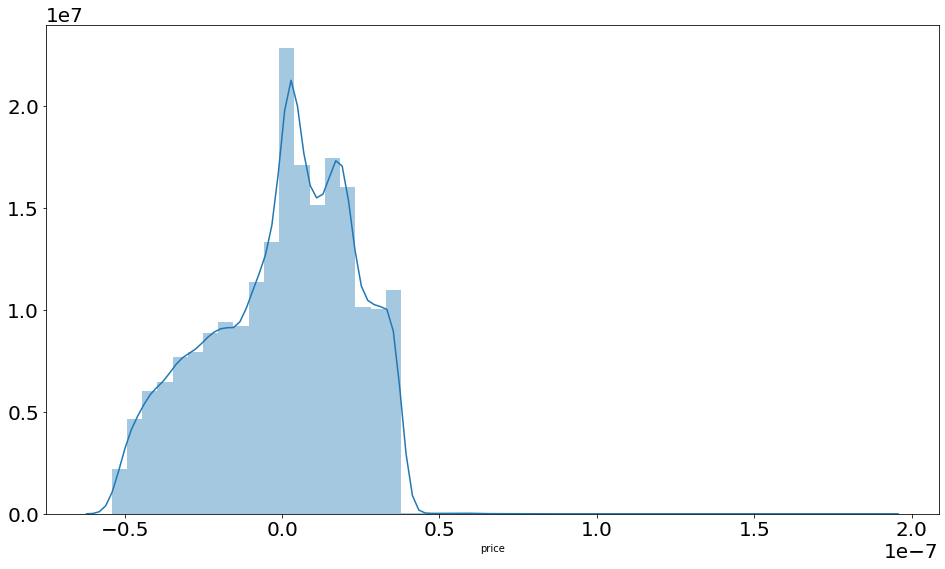

In [130]:
sns.distplot((y_test-predictions))

In [136]:
print('MAE :', metrics.mean_absolute_error(y_test,predictions))

MAE : 1.8380013887346743e-08


In [134]:
print('MSE :', metrics.mean_squared_error(y_test,predictions))

5.024179456762341e-16

In [135]:
print('RMSE :', np.sqrt(metrics.mean_squared_error(y_test,predictions)))

2.2414681476127073e-08